In [1]:
import torch
import math
import numpy as np
import torch 
import matplotlib.pyplot as plt
from lru.architectures import DWN, DWNConfig
import nonlinear_benchmarks

In [2]:
# Load training results
ckpt = torch.load("ckpt.pt")

In [3]:
# Load model
cfg = ckpt["cfg"]
config = DWNConfig(d_model=cfg.d_model, d_state=cfg.d_state, n_layers=cfg.n_layers, ff=cfg.ff, max_phase=math.pi)
model = DWN(cfg.n_u, cfg.n_y, config)
model.load_state_dict(ckpt["model"])
n_params = sum(map(torch.numel, model.parameters()))
print(f"Number of parameters: {n_params}")

Number of parameters: 496


In [4]:
# Load test data
_, test = nonlinear_benchmarks.WienerHammerBenchMark()
u_test, y_test = test
u_test = u_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [5]:
# Load scalers
scaler_u = ckpt["scaler_u"]
scaler_y = ckpt["scaler_y"]

In [6]:
# Scale u, simulate, and inverse scale result
ut = torch.tensor(scaler_u.transform(u_test)).unsqueeze(0).float()
with torch.no_grad():
    y_test_hat = model(ut).squeeze(0).to("cpu").numpy()

y_test_hat = scaler_y.inverse_transform(y_test_hat)

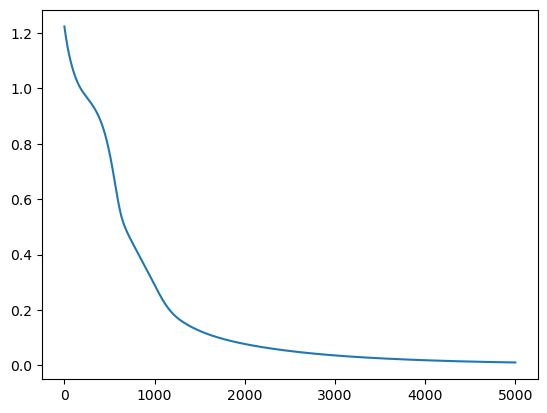

In [7]:
plt.figure()
plt.plot(ckpt["LOSS"])

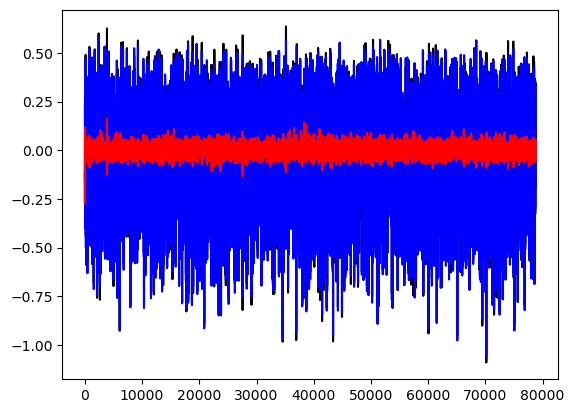

In [8]:

plt.figure()
plt.plot(y_test, "k")
plt.plot(y_test_hat, "b")
plt.plot(y_test_hat - y_test, "r")
plt.show()

In [9]:
mse = np.mean((y_test_hat - y_test)**2)
rmse = np.sqrt(mse) * 1000
print(f"{rmse=} mV") 

rmse=25.24173877317514 mV


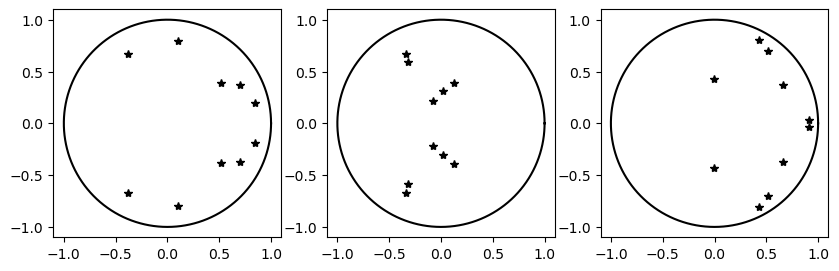

In [10]:
fig, ax = plt.subplots(1, config.n_layers, figsize=(10,5))
t = np.linspace(0, 2*np.pi, 1000)
for idx, layer in enumerate(model.blocks):#range(config.n_layers):
    lambdas, B, C, D = model.blocks[idx].lru.ss_params()
    lambdas = lambdas.detach()
    ax[idx].plot(np.cos(t), np.sin(t), "-k")
    ax[idx].plot(lambdas.real, lambdas.imag, "k*")#lambdas.real
    ax[idx].plot(lambdas.real, -lambdas.imag, "k*")#lambdas.real
    ax[idx].set_box_aspect(1)